# NLP Classification using LSTM
- This tutorial covers developing an `LSTM` model to classify text data.
- Dataset used for analysis is [Clickbait Dataset](https://www.kaggle.com/datasets/amananandrai/clickbait-dataset) taken from Kaggle website.
- Binary classification models are developed on this dataset to identify if the given news headline text a clickbait headline or not
- Two different LSTM models are built in the `Tensorflow` framework:
  - Model 1 calculates new embeddings during model developement.
  - Model 2 uses Stanford's pre-trained glove embeddings
  

In [1]:
# importing libraries necessary for data cleaning, text  pre-processing, model developement etc

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import collections

from matplotlib.legend import Legend
from numpy import array
from numpy import asarray
from numpy import zeros
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [33]:
# # download and unzip pre-trained glove embeddings

# !wget  -P '/content/' 'http://nlp.stanford.edu/data/glove.6B.zip'
# !unzip '/content/glove.6B.zip' -d '/content/glove/'

### 1. Data import and Target definition

In [3]:
#importing model development data

df = pd.read_csv('/content/Clickbait.csv')
print(df.head())
print(df.tail())
print(df.shape)

                                            headline  clickbait
0                                 Should I Get Bings          1
1      Which TV Female Friend Group Do You Belong In          1
2  The New "Star Wars: The Force Awakens" Trailer...          1
3  This Vine Of New York On "Celebrity Big Brothe...          1
4  A Couple Did A Stunning Photo Shoot With Their...          1
                                                headline  clickbait
31995  To Make Female Hearts Flutter in Iraq, Throw a...          0
31996  British Liberal Democrat Patsy Calton, 56, die...          0
31997  Drone smartphone app to help heart attack vict...          0
31998  Netanyahu Urges Pope Benedict, in Israel, to D...          0
31999  Computer Makers Prepare to Stake Bigger Claim ...          0
(32000, 2)


In [4]:
df.columns

Index(['headline', 'clickbait'], dtype='object')

In [5]:
df1 = df.copy()

### 2. Text data cleaning and pre-processing

In [6]:
# Removing HTTP tags from 'headline' column and saving results in a new column : 'headline_processed'
df1['headline_processed'] = (df1['headline']
                             .map(lambda x : ' '.join(re.sub('(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)','',x).split())))
df1.head()

,headline,clickbait,headline_processed
0,Should I Get Bings,1,Should I Get Bings
1,Which TV Female Friend Group Do You Belong In,1,Which TV Female Friend Group Do You Belong In
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1,The New Star Wars The Force Awakens Trailer Is...
3,"This Vine Of New York On ""Celebrity Big Brothe...",1,This Vine Of New York On Celebrity Big Brother...
4,A Couple Did A Stunning Photo Shoot With Their...,1,A Couple Did A Stunning Photo Shoot With Their...


In [7]:
# Converting the text in 'headline_processed' column to lowercase
df1['headline_processed'] = (df1['headline_processed']
                             .map(lambda x: x.lower()))
df1.head()

,headline,clickbait,headline_processed
0,Should I Get Bings,1,should i get bings
1,Which TV Female Friend Group Do You Belong In,1,which tv female friend group do you belong in
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1,the new star wars the force awakens trailer is...
3,"This Vine Of New York On ""Celebrity Big Brothe...",1,this vine of new york on celebrity big brother...
4,A Couple Did A Stunning Photo Shoot With Their...,1,a couple did a stunning photo shoot with their...


In [8]:
# Converting the text in 'headline_processed' column to lowercase
df1['headline_processed'] = (df1['headline_processed']
                             .map(lambda x: re.sub(r'[^\w\s]', '', x)))
df1.head()

,headline,clickbait,headline_processed
0,Should I Get Bings,1,should i get bings
1,Which TV Female Friend Group Do You Belong In,1,which tv female friend group do you belong in
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1,the new star wars the force awakens trailer is...
3,"This Vine Of New York On ""Celebrity Big Brothe...",1,this vine of new york on celebrity big brother...
4,A Couple Did A Stunning Photo Shoot With Their...,1,a couple did a stunning photo shoot with their...


In [9]:
# Removing punctuations from the text in 'headline_processed' column to lowercase
df1['headline_processed'] = (df1['headline_processed']
                             .map(lambda x : re.sub(r'[^\x00-\x7F]+', '', x)))
df1.head()

,headline,clickbait,headline_processed
0,Should I Get Bings,1,should i get bings
1,Which TV Female Friend Group Do You Belong In,1,which tv female friend group do you belong in
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1,the new star wars the force awakens trailer is...
3,"This Vine Of New York On ""Celebrity Big Brothe...",1,this vine of new york on celebrity big brother...
4,A Couple Did A Stunning Photo Shoot With Their...,1,a couple did a stunning photo shoot with their...


In [10]:
# Creating new dataframe with processed text and target label
df2 = df1[['clickbait', 'headline_processed']]
df2.head()

,clickbait,headline_processed
0,1,should i get bings
1,1,which tv female friend group do you belong in
2,1,the new star wars the force awakens trailer is...
3,1,this vine of new york on celebrity big brother...
4,1,a couple did a stunning photo shoot with their...


In [11]:
# shuffling the dataframe so that target class rows are randomly distributed
df2 = df2.sample(frac=1).reset_index(drop=True)
print(df2.head())
print(df2.tail())

   clickbait                                 headline_processed
0          0                nokia launches internet music store
1          1  18 pointlessly gendered products thatll destro...
2          0              moderate elected president in somalia
3          0  faster racing suits may soon be banned from co...
4          0       us extends its inquiry of offshore tax fraud
       clickbait                                 headline_processed
31995          0  tropical storm carlos restrengthens over the p...
31996          0  census finds fewer homes have a child in resid...
31997          1                a better way to fold a fitted sheet
31998          1  24 adorable products every cat lover needs in ...
31999          1  halsey opened up about what its like living wi...


In [12]:
# checking the word-length of the longest headline sentence in headline_processed column  
longest_headline = max(df2['headline_processed'], key=len)
print('Longest Headline: {}'.format(longest_headline))
max_len = len(longest_headline.split())
print('Total words in longest the headline: {}'.format(max_len))

# checking the word-length of the shortest headline sentence in headline_processed column
shortest_headline = min(df2['headline_processed'], key=len)
print('Shortest Headline: {}'.format(shortest_headline))
min_len = len(shortest_headline.split())
print('Total Words in shortest the headline: {}'.format(min_len))

Longest Headline: common sense advisory announces size of worldwide translation and localization market and ranking of top 20 language services companies
Total words in longest the headline: 19
Shortest Headline: bfwknd
Total Words in shortest the headline: 1


### 3. Model Development

#### 3.1 Dataset transformations and other Utility functions for model development

In [13]:
# splitting model development data into training and testing data
X, Y = df2['headline_processed'], df2['clickbait']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=21)

In [14]:
# using tokenizer functionality to create a vocab dictionary
top_n_words = 15000
tokenizer = Tokenizer(num_words=top_n_words, oov_token = '<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index)
print('Total Unique Words = {}'.format(vocab_size))

Total Unique Words = 22216


In [15]:
print('5 most common Key-Value pairs in word_index')
print(collections.Counter(word_index).most_common(5))

5 most common Key-Value pairs in word_index
[('resisting', 22216), ('chimp', 22215), ('bonobo', 22214), ('oc', 22213), ('dusk', 22212)]


In [16]:
# converting text data into sequence of numbers using tokenizer reference
# padding the sequences so that all training examples have the same length(length of longest sentence)
 
X_train_sequence = tokenizer.texts_to_sequences(X_train)
print('First Headline : {}'.format(X_train[0]))
print('First Headline as tokenized sequence : {}'.format(X_train_sequence[0]))
print('Length before padding:\nSample 0 = {} and Sample 1 = {}'.format(len(X_train_sequence[0]),
                                                                       len(X_train_sequence[1])))
X_train_sequence_padded = pad_sequences(X_train_sequence, padding='post', maxlen=max_len)
print('First Headline as padded tokenized sequence : {}'.format(X_train_sequence_padded[0]))
print('Length after padding:\nSample 0 = {} and Sample  1= {}'.format(len(X_train_sequence_padded[0]),
                                                                      len(X_train_sequence_padded[1])))
print('Training sample 0:\n{}'.format(X_train_sequence_padded[0]))

X_test_sequence = tokenizer.texts_to_sequences(X_test)
X_test_sequence_padded = pad_sequences(X_test_sequence, padding='post',
                                       maxlen=max_len, truncating='post')

print('Training tensor dimensions: ', X_train_sequence_padded.shape)
print('Testing tensor dimensions: ', X_test_sequence_padded.shape)

First Headline : nokia launches internet music store
First Headline as tokenized sequence : [5612, 11677, 53, 11678, 370, 9, 4, 2590, 4335]
Length before padding:
Sample 0 = 9 and Sample 1 = 8
First Headline as padded tokenized sequence : [ 5612 11677    53 11678   370     9     4  2590  4335     0     0     0
     0     0     0     0     0     0     0]
Length after padding:
Sample 0 = 19 and Sample  1= 19
Training sample 0:
[ 5612 11677    53 11678   370     9     4  2590  4335     0     0     0
     0     0     0     0     0     0     0]
Training tensor dimensions:  (25600, 19)
Testing tensor dimensions:  (6400, 19)


In [17]:
# downloading and saving glove embeddings

glove_dictionary = dict()
glove_file = open('/content/glove/glove.6B.100d.txt', encoding='utf8')

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    glove_dictionary [word] = vector_dimensions

glove_file.close()

In [18]:
# creating a word-embedding matrix from glove-embeddings, with embedding size=100

vocab_size = vocab_size + 1
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = glove_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [19]:
# function to check model performance on train and test data set

def model_performance_plot(model_history, metric, title):
  plt.plot(model_history.history['{}'.format(metric)])
  plt.plot(model_history.history['val_{}'.format(metric)])
  plt.title(title)
  plt.ylabel('{}'.format(metric))
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper right')
  plt.show()

In [20]:
# function to check model performance on test dataset

def test_data_performance(mdl, x, y):
  result_dictionary = mdl.evaluate(X_test_sequence_padded, Y_test, return_dict=True, verbose=0)
  model_performance = pd.DataFrame([result_dictionary.values()], columns=[list(result_dictionary.keys())])
  model_performance['loss'] = round((model_performance['loss']),4)
  model_performance['accuracy'] = round((model_performance['accuracy'])*100,2)
  model_performance.index = ['Value']   
  print('Performance on Test data:\n{}'.format(model_performance))

#### 3.2.1 Model development without Glove Embedding

In [21]:
#clear state
tf.keras.backend.clear_session()
np.random.seed(21)

In [22]:
# build model : embedding_size=128, 2 layers of LSTM, 64 units in Layer1 and 16 unites in Layer2

embedding_size = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(LSTM(64,return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 19, 128)           2843776   
                                                                 
 lstm (LSTM)                 (None, 19, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 16)                5184      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 2,898,385
Trainable params: 2,898,385
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
# fit the model

callbacks = EarlyStopping(monitor='val_loss', patience=3)

lstm_basic_history = model.fit(X_train_sequence_padded, Y_train, validation_split=0.2,
                               epochs=8, batch_size=512, verbose=1, callbacks = callbacks)

Epoch 1/8
40/40 [==============================] - 10s 170ms/step - loss: 0.3832 - accuracy: 0.8251 - val_loss: 0.1224 - val_accuracy: 0.9691
Epoch 2/8
40/40 [==============================] - 6s 148ms/step - loss: 0.0689 - accuracy: 0.9827 - val_loss: 0.0806 - val_accuracy: 0.9746
Epoch 3/8
40/40 [==============================] - 6s 148ms/step - loss: 0.0277 - accuracy: 0.9937 - val_loss: 0.0804 - val_accuracy: 0.9717
Epoch 4/8
40/40 [==============================] - 6s 146ms/step - loss: 0.0123 - accuracy: 0.9978 - val_loss: 0.0981 - val_accuracy: 0.9723
Epoch 5/8
40/40 [==============================] - 6s 149ms/step - loss: 0.0063 - accuracy: 0.9992 - val_loss: 0.1133 - val_accuracy: 0.9703
Epoch 6/8
40/40 [==============================] - 6s 146ms/step - loss: 0.0040 - accuracy: 0.9996 - val_loss: 0.1193 - val_accuracy: 0.9717


#### 3.2.2 Evaluation for model without Glove Embedding

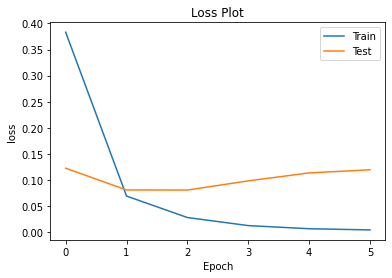

In [24]:
model_performance_plot(lstm_basic_history, 'loss', 'Loss Plot')

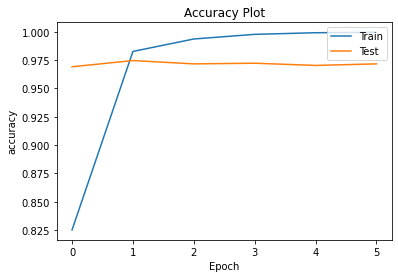

In [25]:
model_performance_plot(lstm_basic_history, 'accuracy', 'Accuracy Plot')

In [26]:
test_data_performance(model,X_test_sequence_padded, Y_test)

Performance on Test data:
         loss accuracy
Value  0.1063    97.48


#### 3.3.1 Model development with Glove Embedding

In [27]:
#clear states
tf.keras.backend.clear_session()
np.random.seed(21)

In [28]:
# build model : embedding_size=100, 2 layers of LSTM, 64 units in Layer1 and 16 unites in Layer2

model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_len,
                    weights=[embedding_matrix], trainable=False))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(8))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 19, 100)           2221700   
                                                                 
 lstm (LSTM)                 (None, 19, 32)            17024     
                                                                 
 lstm_1 (LSTM)               (None, 8)                 1312      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 2,240,045
Trainable params: 18,345
Non-trainable params: 2,221,700
_________________________________________________________________
None


In [29]:
# fit the model

callbacks = EarlyStopping(monitor='val_loss', patience=3)

lstm_glove_history = model.fit(X_train_sequence_padded, Y_train, validation_split=0.2,
                               epochs=8, batch_size=512, verbose=1)

Epoch 1/8
40/40 [==============================] - 6s 78ms/step - loss: 0.5589 - accuracy: 0.8015 - val_loss: 0.3776 - val_accuracy: 0.9209
Epoch 2/8
40/40 [==============================] - 2s 57ms/step - loss: 0.2790 - accuracy: 0.9384 - val_loss: 0.2088 - val_accuracy: 0.9494
Epoch 3/8
40/40 [==============================] - 2s 57ms/step - loss: 0.1799 - accuracy: 0.9554 - val_loss: 0.1597 - val_accuracy: 0.9600
Epoch 4/8
40/40 [==============================] - 2s 57ms/step - loss: 0.1420 - accuracy: 0.9638 - val_loss: 0.1392 - val_accuracy: 0.9637
Epoch 5/8
40/40 [==============================] - 2s 57ms/step - loss: 0.1240 - accuracy: 0.9658 - val_loss: 0.1328 - val_accuracy: 0.9623
Epoch 6/8
40/40 [==============================] - 2s 56ms/step - loss: 0.1110 - accuracy: 0.9695 - val_loss: 0.1342 - val_accuracy: 0.9594
Epoch 7/8
40/40 [==============================] - 2s 55ms/step - loss: 0.1005 - accuracy: 0.9711 - val_loss: 0.1158 - val_accuracy: 0.9660
Epoch 8/8
40/40 [===

#### 3.3.2 Evaluation for model with Glove Embedding

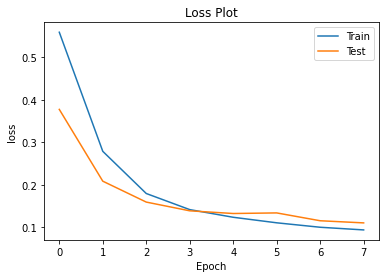

In [30]:
model_performance_plot(lstm_glove_history, 'loss', 'Loss Plot')

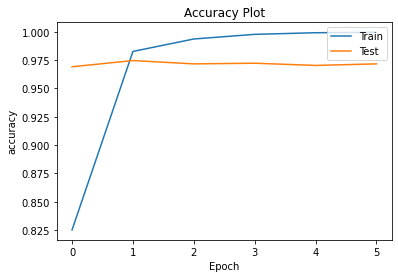

In [31]:
model_performance_plot(lstm_basic_history, 'accuracy', 'Accuracy Plot')

In [32]:
test_data_performance(model, X_test_sequence_padded, Y_test)

Performance on Test data:
         loss accuracy
Value  0.1044    96.86
